# 03 — SVM + Bag of Words (TF-IDF)

Classificador **LinearSVC** com features TF-IDF (unigrams + bigrams).

**Configuração:**
- TfidfVectorizer: max_features=50K, ngram_range=(1,2), min_df=3, max_df=0.95
- LinearSVC com class_weight='balanced'
- GridSearchCV: C=[0.1, 1, 10], cv=3, scoring='f1_weighted'

In [1]:
import sys
sys.path.insert(0, "..")

import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV
import joblib

from src.config import SVM_C_VALUES, MODELS_DIR, SEED
from src.data_loader import carregar_splits
from src.feature_extraction import construir_tfidf
from src.evaluation import calcular_metricas, salvar_metricas, plotar_matriz_confusao
from src.utils import set_seed, timer

set_seed()

## 1. Carregar Dados Preprocessados

In [2]:
df_train, df_val, df_test = carregar_splits()

# Usar textos preprocessados para SVM
textos_treino = df_train["texto_svm"].fillna("").tolist()
textos_val = df_val["texto_svm"].fillna("").tolist()
textos_teste = df_test["texto_svm"].fillna("").tolist()

y_train = df_train["label"].values
y_val = df_val["label"].values
y_test = df_test["label"].values

print(f"Treino: {len(textos_treino):,} | Val: {len(textos_val):,} | Teste: {len(textos_teste):,}")

Splits carregados: treino=90,368 | val=19,365 | teste=19,365
Treino: 90,368 | Val: 19,365 | Teste: 19,365


## 2. TF-IDF Vectorization

In [3]:
with timer("TF-IDF Vectorization"):
    vectorizer, X_train, X_val, X_test = construir_tfidf(
        textos_treino, textos_val, textos_teste
    )

print(f"X_train: {X_train.shape}")
print(f"X_val:   {X_val.shape}")
print(f"X_test:  {X_test.shape}")

TF-IDF: vocabulário=50,000, shape treino=(90368, 50000)
⏱ TF-IDF Vectorization: 2.8s
X_train: (90368, 50000)
X_val:   (19365, 50000)
X_test:  (19365, 50000)


## 3. GridSearchCV — LinearSVC

In [4]:
param_grid = {"C": SVM_C_VALUES}

svm = LinearSVC(
    class_weight="balanced",
    random_state=SEED,
    max_iter=10000,
)

with timer("GridSearchCV"):
    grid = GridSearchCV(
        svm,
        param_grid,
        cv=3,
        scoring="f1_weighted",
        verbose=1,
        n_jobs=-1,
    )
    grid.fit(X_train, y_train)

print(f"\nMelhor C: {grid.best_params_['C']}")
print(f"Melhor F1 (CV): {grid.best_score_:.4f}")

Fitting 3 folds for each of 3 candidates, totalling 9 fits


⏱ GridSearchCV: 15.8s

Melhor C: 0.1
Melhor F1 (CV): 0.8120


## 4. Avaliação no Validação

In [5]:
best_svm = grid.best_estimator_

y_val_pred = best_svm.predict(X_val)
metricas_val = calcular_metricas(y_val, y_val_pred, "SVM+BoW (Val)")


Resultados: SVM+BoW (Val)
Accuracy:  0.8199
F1 (weighted): 0.8148
Precision: 0.8116
Recall:    0.8199

Classification Report:
              precision    recall  f1-score   support

    negativo       0.81      0.89      0.85      5066
      neutro       0.42      0.34      0.38      2401
    positivo       0.89      0.89      0.89     11898

    accuracy                           0.82     19365
   macro avg       0.71      0.71      0.70     19365
weighted avg       0.81      0.82      0.81     19365



## 5. Avaliação no Teste

In [6]:
y_test_pred = best_svm.predict(X_test)
metricas_teste = calcular_metricas(y_test, y_test_pred, "SVM+BoW")
salvar_metricas(metricas_teste)


Resultados: SVM+BoW
Accuracy:  0.8170
F1 (weighted): 0.8110
Precision: 0.8071
Recall:    0.8170

Classification Report:
              precision    recall  f1-score   support

    negativo       0.81      0.89      0.85      5066
      neutro       0.40      0.32      0.36      2402
    positivo       0.89      0.89      0.89     11897

    accuracy                           0.82     19365
   macro avg       0.70      0.70      0.70     19365
weighted avg       0.81      0.82      0.81     19365

Métricas salvas em /Users/devsquad/PLN-sentiments/models/metricas_svm+bow.json


PosixPath('/Users/devsquad/PLN-sentiments/models/metricas_svm+bow.json')

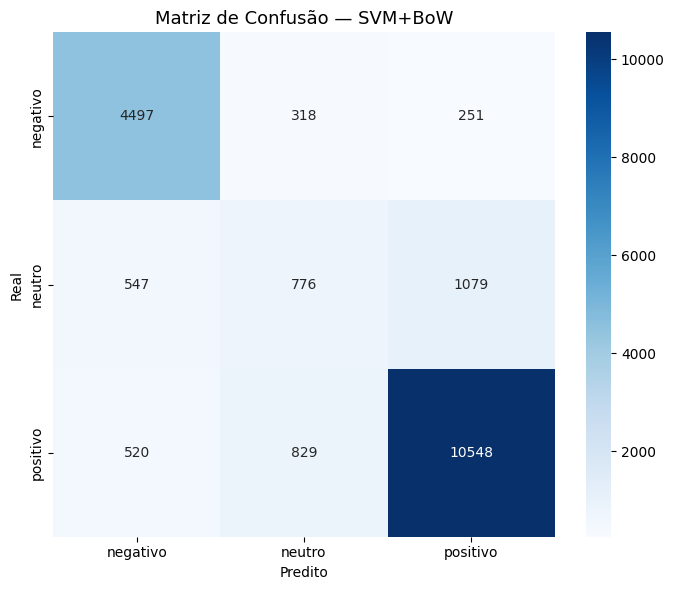

In [7]:
fig = plotar_matriz_confusao(y_test, y_test_pred, "SVM+BoW")
plt.show()

## 6. Salvar Modelo

In [8]:
MODELS_DIR.mkdir(parents=True, exist_ok=True)
joblib.dump(best_svm, MODELS_DIR / "svm_bow.joblib")
joblib.dump(vectorizer, MODELS_DIR / "tfidf_vectorizer.joblib")
print("Modelo e vectorizer salvos!")

Modelo e vectorizer salvos!


## Resumo

- LinearSVC treinado com TF-IDF (50K features, unigrams+bigrams)
- GridSearchCV encontrou melhor C
- Métricas salvas para comparação final
- Próximo passo: **04_svm_embeddings.ipynb**